For this analysis, only reads with a mapping quality of 10 or greater and bases with a base quality of 20 or greater were included.

In [20]:
source("chimothers.R")

In [3]:
vcf_file <- "~/Desktop/chimamas/merged_filtered.vcf"
reads_file <- "~/Desktop/chimamas//all_read_counts.csv"

print(ProcessVCF)
processed_vcf <- ProcessVCF(vcf_file)

function (vcf_file) 
{
    BASES <- c("A", "C", "G", "T")
    vcf <- fread(vcf_file, skip = "#CHROM") %>% filter(REF %in% 
        BASES, ALT %in% BASES) %>% rename(CHROM = `#CHROM`) %>% 
        mutate(CHROM = paste0("chr", CHROM))
    vcf_long <- vcf %>% select(-ID, -QUAL, -FILTER, -INFO) %>% 
        gather(sample, info, -CHROM, -POS, -REF, -ALT, -FORMAT) %>% 
        as.data.table()
    REL_DICT <- c(ChA = "Child", CHA = "Child", ChC = "Child", 
        FA = "Father", FC = "Father", jMC = "Mother", GFFC = "GP", 
        GFFH = "GP", GMFC = "GP", kGFMC = "GP", kGFMH = "GP", 
        lGMMC = "GP", lGMMH = "GP")
    vcf_long2 <- copy(vcf_long)
    vcf_long2[FORMAT == "GT:AD:DP:GQ:PL", `:=`(c("GT", "AD", 
        "DP", "GQ", "PL"), tstrsplit(info, ":", fixed = T))]
    vcf_long2[FORMAT == "GT:DP:AD:GQ:PL", `:=`(c("GT", "DP", 
        "AD", "GQ", "PL"), tstrsplit(info, ":", fixed = T))]
    vcf_long2[DP == ".", `:=`(DP = "0")]
    vcf_long2[, `:=`(DP = as.numeric(DP))]
    vcf_long2[, `

In [4]:
family_rels <- c("Father", "Mother", "Child")

vcf_trios <- processed_vcf %>%
  filter(rel %in% family_rels)

In [5]:
family_stats <- vcf_trios %>%
  group_by(family) %>%
  summarise(num_family_members = length(unique(sample)), 
            has_m_f_c = all(family_rels %in% rel))

has_three <- family_stats %>%
  filter(has_m_f_c, 
         num_family_members == 3)

chr_counts <- vcf_trios %>%
  filter(family %in% has_three$family) %>%
  filter(rel %in% c("Mother", "Father")) %>%
  group_by(family, rel, CHROM) %>%
  summarise(total_count = sum(DP))
  
ratio <- chr_counts %>%
  group_by(family, rel) %>%
  summarise(chrYtochr7 = 1000 * total_count[CHROM == "chrY"] / total_count[CHROM == "chr7"]) %>%
  spread(rel, chrYtochr7)

# SNPs in the VCF

This is a table of the chromosome of SNPs in the VCF. The unit of observation is the SNP.

In [6]:
processed_vcf %>%
  group_by(CHROM) %>% 
  summarise(n = n_distinct(POS))

CHROM,n
<chr>,<int>
chr7,2888
chrY,11


# Trios in the VCF
Here is a table of the number of family members we have data for, against whether we have data for a child, mother and father. The unit of observation is the family.


In [7]:
table(family_stats$num_family_members, family_stats$has_m_f_c, dnn = list("# family members", "Full trio"))

                Full trio
# family members FALSE TRUE
               1     8    0
               2     4    0
               3     0   13

# Check sex of parents

To check the sex of the parents we calculate the ratio of total read count for SNPs on chromosome Y to total read count for SNPs on chromosome 7 (multiplied by 1000). Here only families with data for a mother, father and child are included. Each row represents one family. There are not any sex mix-ups.

In [8]:
ratio %>% rename(father_Y_to_7_ratio = Father, mother_Y_to_7_ratio = Mother)

family,father_Y_to_7_ratio,mother_Y_to_7_ratio
<chr>,<dbl>,<dbl>
11,2.176873,0.000000000
15,2.204950,0.000000000
16,6.051213,0.000000000
18,3.567871,0.000000000
19,2.981908,0.000000000
25,2.257567,0.000000000
26,5.541046,0.000000000
3,3.898588,0.000000000
4,2.666948,0.000000000


118374901 is a very noisy SNP close to lots of insertions and deletions. 

In [23]:
print(ProcessReadCounts)
all_dat <- ProcessReadCounts(reads_file, processed_vcf) %>%
  dplyr::select(-AA, -CC, -GG, -TT)

chr7_dat <- all_dat %>%
  filter(CHROM == "chr7") %>%
  select(-CHROM) %>%
  filter(!POS == 118374901, 
         family %in% has_three$family)

function (reads_file, processed_vcf) 
{
    alt_ref <- processed_vcf %>% select(CHROM, POS, VCF_REF = REF, 
        VCF_ALT = ALT) %>% as.data.frame() %>% distinct()
    reads_dat <- fread(reads_file) %>% dplyr::select(-R) %>% 
        mutate(name = gsub(".sam.sorted.bam.base.counts.txt", 
            "", name, fixed = T), REF = toupper(REF)) %>% rename(AA = A, 
        CC = C, GG = G, TT = T) %>% as.data.frame()
    with_alt_ref <- reads_dat %>% inner_join(alt_ref, by = c("CHROM", 
        "POS")) %>% mutate(num_ref = case_when(REF == "A" ~ AA, 
        REF == "C" ~ CC, REF == "G" ~ GG, REF == "T" ~ TT), num_alt = case_when(VCF_ALT == 
        "A" ~ AA, VCF_ALT == "C" ~ CC, VCF_ALT == "G" ~ GG, VCF_ALT == 
        "T" ~ TT))
    joined_dat <- with_alt_ref %>% select(CHROM, POS, name, num_ref, 
        num_alt, AA, CC, GG, TT) %>% inner_join(processed_vcf, 
        by = c("CHROM", "POS", name = "sample")) %>% select(-FORMAT, 
        -info) %>% mutate(num_ref_alt = num_ref + num_alt)
 

# Overall mean depth

The overall average read depth for chromosome 7 is

In [24]:
mean(chr7_dat$num_ref_alt)

[1] 1316.628

# Histogram of depth across all chromosome 7 SNPs

The unit of observation is a SNP in one individual.

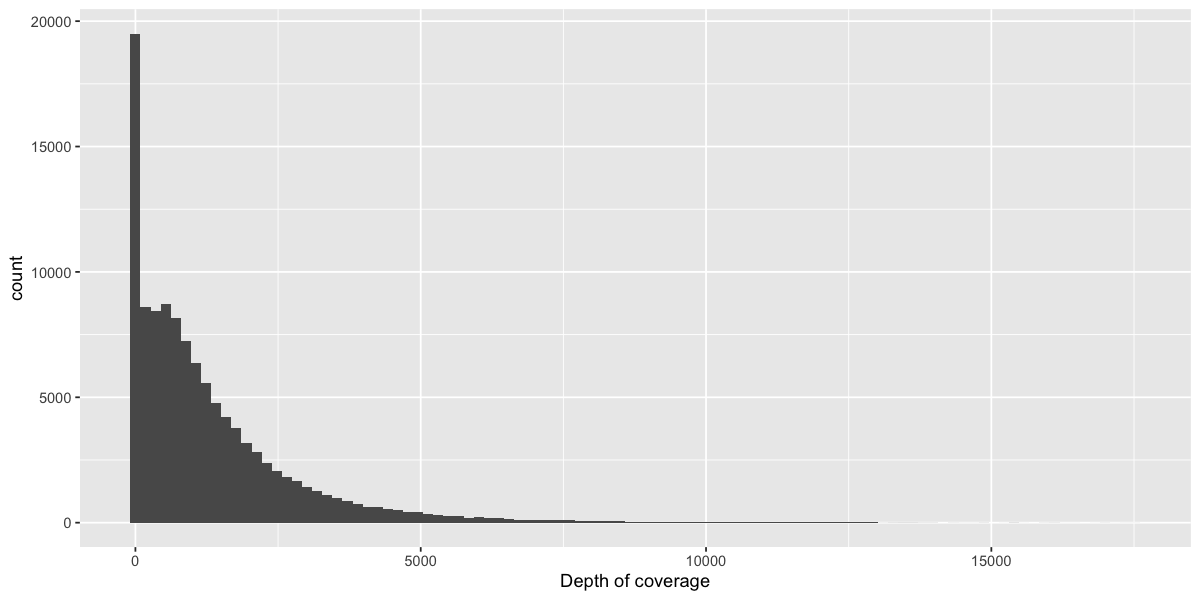

In [25]:
ggplot(chr7_dat, aes(x=num_ref_alt)) +
  geom_histogram(bins = 100) + 
  xlab("Depth of coverage")

# Histogram of mean depth by sample

The unit of observation is an individual.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



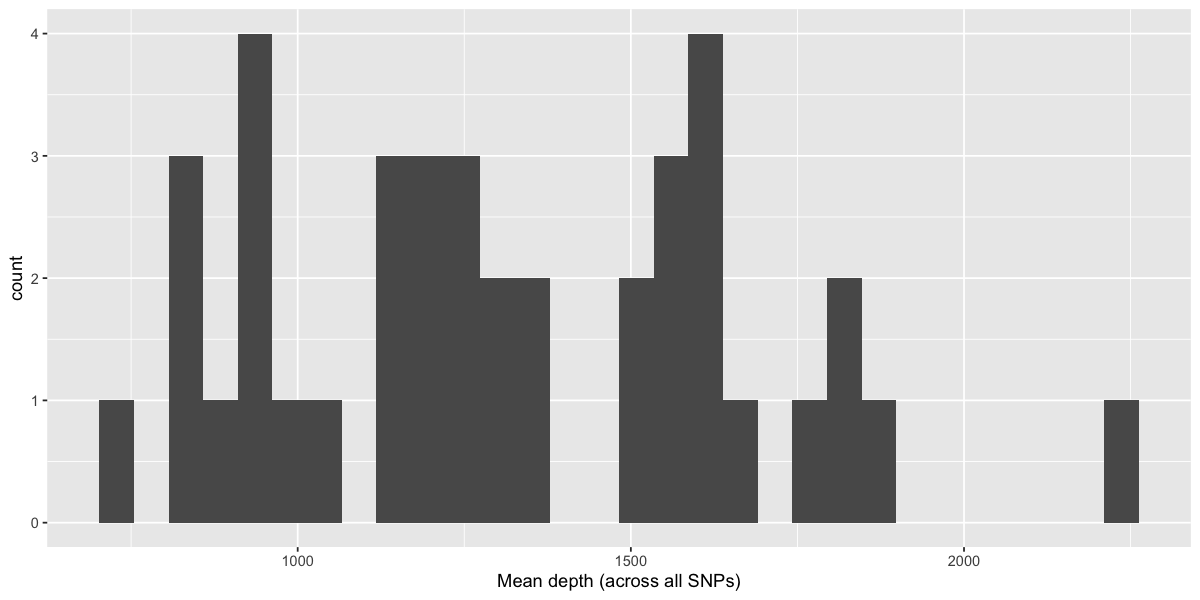

In [26]:
mean_depth_per_sample <- chr7_dat %>%
  group_by(family, rel) %>%
  summarise(mean_num_ref_alt = mean(num_ref_alt))

mean_depth_per_sample %>%
  ggplot(aes(x=mean_num_ref_alt)) + 
  geom_histogram() +
  xlab("Mean depth (across all SNPs)")
  

#mean_depth_per_sample %>%
#  arrange(mean_num_ref_alt) %>%
#  select(family, rel, mean_num_ref_alt) %>%
#  as.data.frame() %>%
#  print()

# Histogram of mean depth by SNP

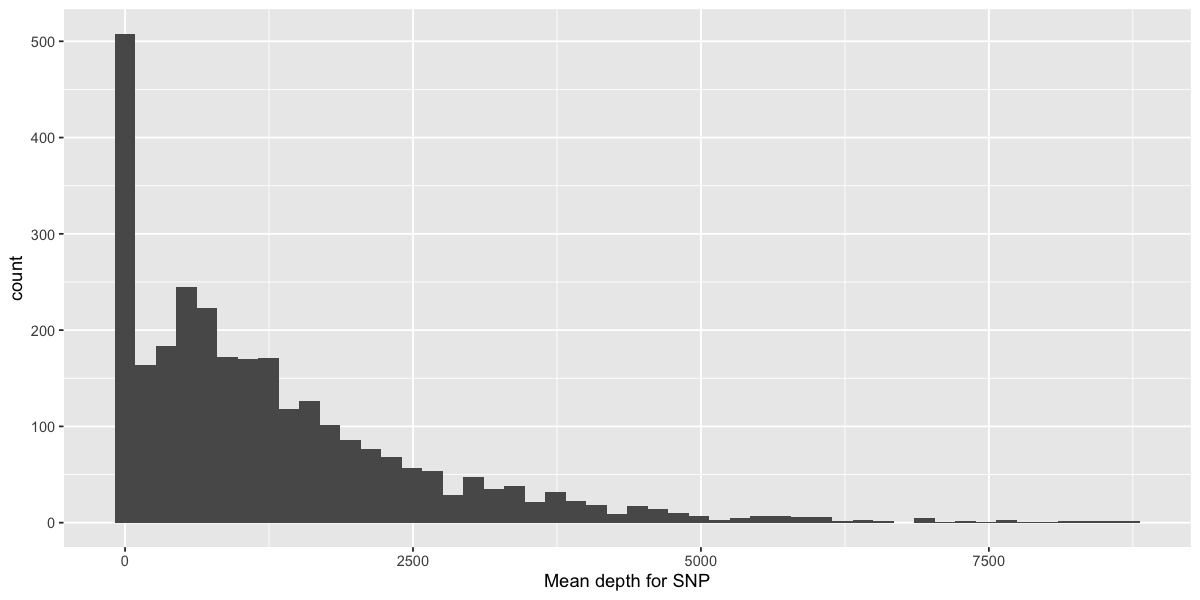

In [27]:
chr7_dat %>%
  group_by(POS) %>%
  summarise(mean_num_ref_alt = mean(num_ref_alt)) %>%
  ggplot(aes(x=mean_num_ref_alt)) + 
  geom_histogram(bins = 50) + 
  xlab("Mean depth for SNP")

# Histogram of reference allele proportion as a function of genotype in VCF

Here the unit of observation is a SNP in one individual.

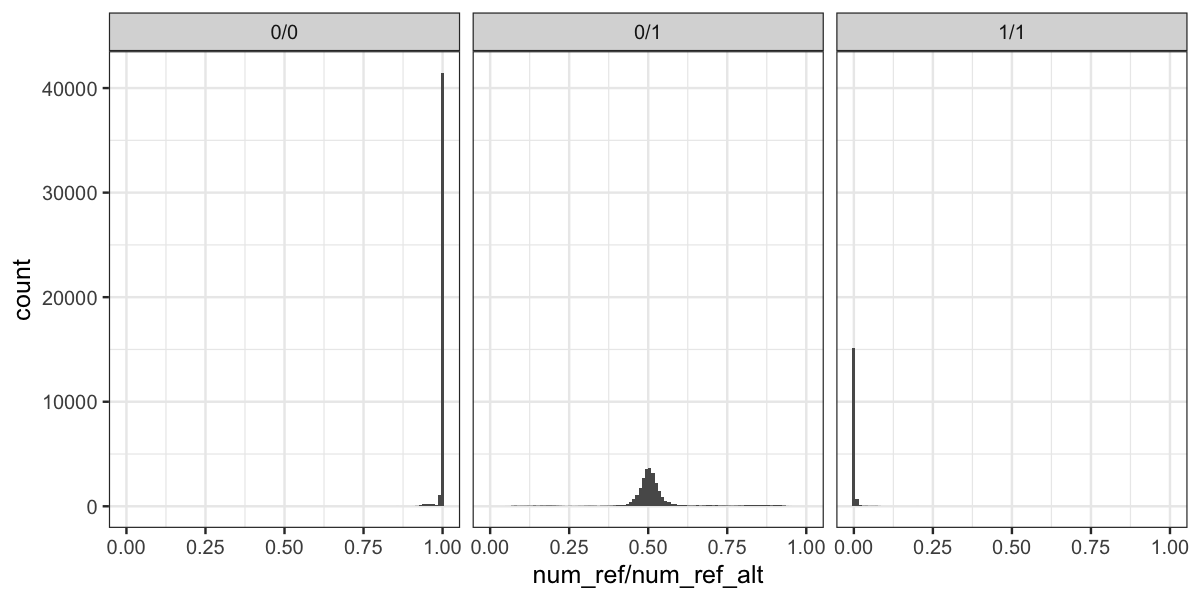

In [28]:
options(repr.plot.width = 10, repr.plot.height = 5)

chr7_dat %>%
  filter(num_ref_alt >= 200) %>%
  ggplot(aes(x=num_ref / num_ref_alt)) + 
  geom_histogram(bins = 100) +
  theme_bw(15) + 
  facet_wrap(~GT)

Below we filter out homozygous SNPs where there are more than 5 reads inconsistent with the homozygous genotype call. Here's a table of how commonly there are more than 5 such reads, by genotype. Also is a plot of the number of inconsistent reads as a function of the number of consistent reads, by genotype. This is limited to observations of SNPs where more than 200 reads are observed. 

GT,More than 5 inconsistent reads (proportion),1 or more inconsistent reads (proportion)
<chr>,<dbl>,<dbl>
0/0,0.08513861,0.5119102
1/1,0.09614546,0.5446167


POS,name,num_ref,num_alt,REF,ALT,GT,AD,DP,GQ,PL,family,rel2,rel,num_ref_alt,num_other
<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>


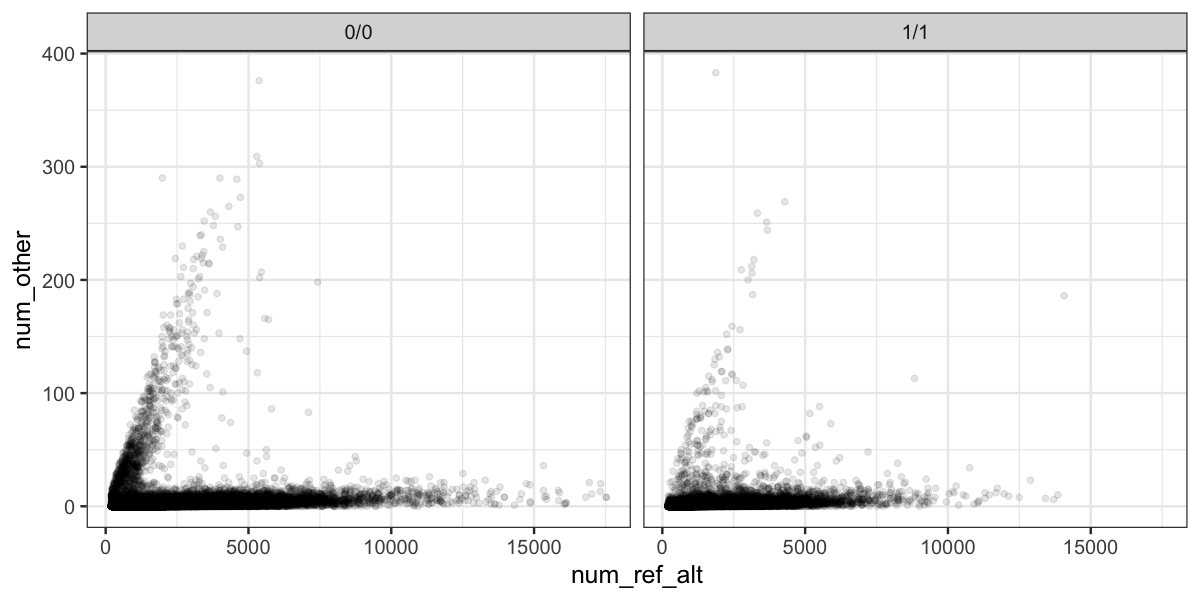

In [29]:
other_hom_data <- chr7_dat %>%
  filter(GT %in% c('0/0', '1/1')) %>%
  filter(num_ref_alt >= 200) %>%
  mutate(num_other = if_else(GT=='0/0', num_alt, num_ref))

other_hom_data %>%
  ggplot(aes(x = num_ref_alt, y = num_other)) + 
  geom_point(alpha=0.1) + 
  theme_bw(15) +
  facet_wrap(~GT)

other_hom_data %>%
  group_by(GT) %>%
  summarise(`More than 5 inconsistent reads (proportion)` = mean(num_other > 5), 
            `1 or more inconsistent reads (proportion)` = mean(num_other > 0))

filter(other_hom_data, num_other >= 500)

total,num_other,n,totalp10,nop10
<dbl>,<dbl>,<int>,<dbl>,<dbl>
200,0,114,210,10
200,10,8,210,20
210,0,214,220,10
210,10,18,220,20
220,0,196,230,10
220,10,10,230,20


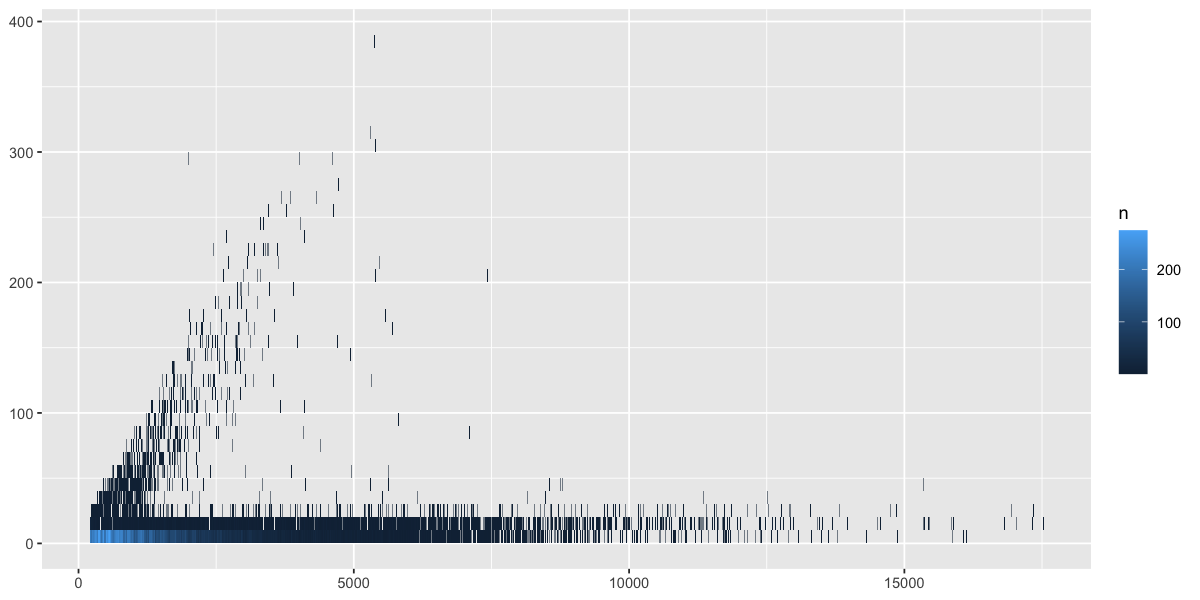

In [30]:
oc <- other_hom_data %>% 
  filter(GT == "0/0") %>% 
  mutate(total = 10 * round(num_ref_alt / 10), 
         num_other = 10 * round(num_other / 10)) %>%
  group_by(total, num_other) %>%
  count() %>%
  mutate(totalp10 = total + 10, 
         nop10 = num_other + 10)
ggplot(oc, aes(xmin=total, xmax = totalp10, ymin=num_other, ymax = nop10, fill = n)) + 
  geom_rect()
head(oc)

Now we filter to only those SNPs where the read counts are highly consistent with the genotype in the VCF. We first filter to SNPs where we have at least 200 reads. For a het SNP we require that the less common allele be observed in at least 30% of reads. For a hom SNP we require that the less common allele be observed in at most 5 reads. We filter to SNPs where the parents have different homozygous genotypes.

In [31]:
print(FilterToHighConfidence)
filtered <- chr7_dat %>%
  FilterToHighConfidence()

has_all_three <- filtered %>%
  group_by(family, POS) %>%
  filter(n() == 3) %>%
  filter(!GT[rel=="Mother"] == GT[rel=="Father"]) %>%
  filter(GT[rel=="Mother"] %in% c("0/0", "1/1"), 
         GT[rel=="Father"] %in% c("0/0", "1/1"))

function (reads_dat) 
{
    reads_dat %>% filter(num_ref_alt >= 200) %>% filter(case_when(GT == 
        "0/1" ~ num_ref/num_ref_alt > 0.3 & num_alt/num_ref_alt > 
        0.3, GT == "0/0" ~ num_alt/num_ref_alt <= 0.025 & num_alt <= 
        20, GT == "1/1" ~ num_ref/num_ref_alt <= 0.025 & num_ref <= 
        20))
    return(reads_dat)
}
<bytecode: 0x7fd42c3cab58>


Now for each family, at SNPs where both parents are homozygous and the child is heterozygous, we compare how often we see the "other" allele in the mother as opposed to the father. If there is microchimerism, we expect to see the other allele more often in mother as opposed to in father. 

In [32]:
fam <- unique(filtered$family)
par <- c("Mother", "Father")
grid <- crossing(fam, par)
res <- pmap_dfr(grid, function(fam, par, dat) {
    family_dat <- dat %>%
      filter(family == fam, 
             rel %in% c(par, "Child"))
    res <- family_dat %>%
      group_by(POS) %>%
      filter(n() == 2) %>%
      summarise(child_genotype = GT[rel == "Child"], 
                parent_genotype = GT[rel == par], 
                parent_both_observed = num_ref[rel == par] > 0 & num_alt[rel == par] > 0, 
                num_ref_par = num_ref[rel==par], 
                num_alt_par = num_alt[rel==par]) %>%
      mutate(parent = par, family = fam)
}, dat = has_all_three)

In [33]:
head(res)

POS,child_genotype,parent_genotype,parent_both_observed,num_ref_par,num_alt_par,parent,family
<int>,<chr>,<chr>,<lgl>,<int>,<int>,<chr>,<chr>
115138715,0/1,1/1,TRUE,1,1365,Father,11
115143073,0/1,1/1,FALSE,0,1926,Father,11
115148976,0/1,1/1,FALSE,0,393,Father,11
115154793,0/1,1/1,FALSE,0,1615,Father,11
115156835,0/1,1/1,TRUE,4,871,Father,11
115170750,0/1,1/1,TRUE,3,2886,Father,11


In [34]:
summ <- res %>%
  mutate(num_ref_alt_par = num_ref_par + num_alt_par, 
         num_other_par = pmin(num_ref_par, num_alt_par)) %>%
  group_by(family, parent, parent_genotype, child_genotype) %>%
  summarise(n = n(),
            n_both_observed = sum(parent_both_observed), 
            mean_prop_other = mean(num_other_par / num_ref_alt_par))

In [35]:
head(summ)

family,parent,parent_genotype,child_genotype,n,n_both_observed,mean_prop_other
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>
11,Father,0/0,0/0,2,0,0.000000000
11,Father,0/0,0/1,131,70,0.001281437
11,Father,1/1,0/0,1,0,0.000000000
11,Father,1/1,0/1,83,46,0.003833049
11,Father,1/1,1/1,2,0,0.000000000
11,Mother,0/0,0/0,1,0,0.000000000


In [36]:
by_parent <- summ %>%
  group_by(family, parent) %>%
  summarise(mean_prop_other = mean(mean_prop_other),
            n_both_observed = sum(n_both_observed), 
            n = sum(n), 
            prop_both_observed = n_both_observed / n)

Here is a table, one row for each parent in the trios, of how often both alleles are observed in the parents. This is restricted to SNPs where parents have different homozygous genotypes. The proportion of such SNPs where both alleles are observed is generally higher in fathers than in mothers. 

In [37]:
by_parent

family,parent,mean_prop_other,n_both_observed,n,prop_both_observed
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
11,Father,0.0010228971,116,219,0.5296804
11,Mother,0.0004375811,93,219,0.4246575
16,Father,0.0025215936,166,223,0.7443946
16,Mother,0.0006249552,108,223,0.4843049
18,Father,0.0015314192,38,83,0.4578313
18,Mother,0.0018917323,36,83,0.4337349
19,Father,0.0009991469,93,202,0.4603960
19,Mother,0.0007287759,85,202,0.4207921
25,Father,0.0151119660,141,368,0.3831522


In [38]:
gt_summary <- by_parent %>%
  group_by(family) %>%
  summarise(`P(other observed) M-F` = prop_both_observed[parent == "Mother"] - prop_both_observed[parent == "Father"],
            `Mean(other allele) M-F` = mean_prop_other[parent == "Mother"] - mean_prop_other[parent == "Father"]) %>%
  mutate(`Other observed more in mother` = `P(other observed) M-F` > 0, 
         `Mean(other) higher in monther ` = `Mean(other allele) M-F` > 0)

In [57]:
mcnemar_pvalues <- res %>%
  filter(!family %in% "7") %>%
  split(.$family) %>%
  map_dfr(function(x) {
    x_spread <- x %>% 
      dplyr::select(POS, parent, parent_both_observed) %>%
      spread(parent, parent_both_observed)
    data.frame(`McNemar test pval` = round(mcnemar.test(x_spread$Father, x_spread$Mother)$p.value, 3), 
              check.names = F)
  }, .id = "family")

This table summarises per family whether the "other" allele is more commonly observed at homozygous SNPs in mother than in father. The p value from a test for matched pairs data is also included. 

In [58]:
left_join(gt_summary, mcnemar_pvalues, by = "family")

family,P(other observed) M-F,Mean(other allele) M-F,Other observed more in mother,Mean(other) higher in monther,McNemar test pval
<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>
11,-0.105022831,-5.853159e-04,FALSE,FALSE,0.027
16,-0.260089686,-1.896638e-03,FALSE,FALSE,0.000
18,-0.024096386,3.603130e-04,FALSE,TRUE,0.855
19,-0.039603960,-2.703710e-04,FALSE,FALSE,0.428
25,0.048913043,-1.464038e-02,TRUE,FALSE,0.162
26,0.081395349,5.057291e-05,TRUE,TRUE,0.047
3,-0.048387097,8.764988e-05,FALSE,TRUE,0.451
4,-0.037735849,-6.431578e-05,FALSE,FALSE,0.544
5,-0.123287671,8.050293e-06,FALSE,TRUE,0.042
